In [2]:
import numpy as np
import pandas as pd
import gym
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image

%matplotlib inline

# K-armed bandits

Esse é o problema mais básico quando se fala de aprendizado por reforço. Com ele, adotamos uma série de simplificações, no entanto já é possível identificar conceitos chave nesse tipo de aplicação:

- imagine que temos uma espécie de jackpot, em que o agente pode escolher entre <b> K </b> alavancas para puxar. Cada alavanca irá trazer uma recompensa em $;

- cada alavanca tem uma recompensa média pré-definida, no entanto cada vez que o agente aciona ela, um fator aleatório é somado ou subtraído da recompensa original;

- o agente tem <b> n </b> "fichas" para acionar as alavancas. O objetivo é ganhar a maior recompensa possível;

- o agente não conhece nenhuma informação do sistema (ambiente) a priori;

Exemplo de uma distribuição de recompensas por alavanca:

In [43]:
means = np.array([1, 6, 6, 5, 7, 7, 2, 9, 5, 7])

samples = {}
for v in range(len(means)):
    samples[v] = means[v] + np.random.randn(1000)
df = pd.DataFrame(samples)

print(means)
fig = px.violin(data_frame =df)
fig.update_layout({
    'title': 'Distribuição recompensas',
    'yaxis_title': 'Retorno $',
    'xaxis_title': 'Alavanca'
})

[1 6 6 5 7 7 2 9 5 7]


## Definindo um Ambiente

Existem bibliotecas para implementação ou uso de ambientes pré-configurados. Veja um exemplo:

In [30]:
class MultiarmedBanditsEnv(gym.Env):
    """
    Environment for multiarmed bandits
    
    fonte: https://github.com/magni84/gym_bandits/blob/master/gym_bandits/envs/bandits_env.py
    
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, nr_arms=10):
        self.action_space = gym.spaces.Discrete(nr_arms)
        self.observation_space = gym.spaces.Discrete(1)
        self.state = 0
        self.reset()


    def step(self, action):
        assert self.action_space.contains(action)
        random_factor = np.random.normal(scale=1)
        reward =  self.values[action] + random_factor
        
        return self.state, reward, False, {self.optimal}

    def reset(self):
        self.values = np.random.randint(0,10,self.action_space.n)
        self.optimal = np.argmax(self.values)
        return self.state

    def render(self, mode='human', close=False):
        print("You are playing a %d-armed bandit" % self.action_space.n)

## Primeiro Experimento

In [31]:
n_alavancas=10

<b> Vamos fazer um exerimento: </b> se o agente tivesse 1000 fichas e acionasse as alavancas de forma aleatória, qual seria seu desempenho?

In [38]:
env = MultiarmedBanditsEnv(nr_arms=n_alavancas)

In [39]:
env.values

array([1, 6, 6, 5, 7, 7, 2, 9, 5, 7])

In [40]:
env.step(0)

(0, 1.1651351085025232, False, {7})

In [41]:
n_steps = 1000
n_alavancas = 10

res = [] #holder para historizar resultados

print(f"Jogando com {n_steps} fichas")

for n in range(n_steps):
    
    action = np.random.randint(n_alavancas)
    state, reward, terminal, info = env.step(action)
    
    resultado = {
        'ficha': n,
        'action': action,
        'recompensa': reward,
        'melhor_acao': env.optimal,
        'recompensa_maxima': np.max(env.values)
    }
    
    res.append(resultado)
res = pd.DataFrame(res).set_index('ficha')
aproveitamento = np.round(100*res['recompensa'].sum()/res['recompensa_maxima'].sum(),1)
print(f'Feito! Aproveitamento: {aproveitamento}%')

Jogando com 1000 fichas
Feito! Aproveitamento: 62.6%


In [45]:
fig = px.line(res[['recompensa', 'recompensa_maxima']])
fig.update_layout({
    'title': 'Recompensa x Passo',
    'yaxis_title': 'Recompensa [$]',
    'xaxis_title': 'Ficha jogada',
})

## Como ter comparações mais confiáveis?

Dependendo do nível de aleatoriedade do sistema, é necessário repetir um experimento diversas vezes até ter uma estimativa confiável de quão bem um agente se sai:

In [46]:
n_runs = 200
n_steps = 1000
n_alavancas = 10

print(f"Jogando {n_runs} vezes com {n_steps} fichas:")

all_rewards = []
all_max_reward = []

for run in tqdm(range(n_runs)):
    run_reward = []
    run_best_reward = []
    for n in range(n_steps):

        action = np.random.randint(n_alavancas)
        state, reward, terminal, info = env.step(action)

        run_reward.append(reward)
        run_best_reward.append(np.max(env.values))
    
    all_rewards.append(run_reward)
    all_max_reward.append(run_best_reward)
    
avg_reward = np.mean(all_rewards, axis=0)
avg_best_reward = np.mean(all_max_reward,axis=0)

res = pd.DataFrame(zip(avg_reward, avg_best_reward), columns=['recompensa_media', 'recompensa_maxima'])
aproveitamento = np.round(100*res['recompensa_media'].sum()/res['recompensa_maxima'].sum(),1)
print(f'Feito! Aproveitamento: {aproveitamento}%')

  2%|█▋                                                                                | 4/200 [00:00<00:06, 30.17it/s]

Jogando 200 vezes com 1000 fichas:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.43it/s]

Feito! Aproveitamento: 61.1%


In [47]:
fig = px.line(res[['recompensa_media', 'recompensa_maxima']])
fig.update_layout({
    'title': 'Recompensa x Passo',
    'yaxis_title': 'Recompensa [$]',
    'xaxis_title': 'Ficha jogada',
})


In [63]:
np.mean(env.values)

5.5

## Como podemos melhorar nossas ações?

Até aqui já podemos identificar alguns conceitos básicos:

- <b> Ambiente </b>: objeto de interação que provê uma recompensa, tem um conjunto de ações e estados;
- <b> Recompensa </b>: sinal escalar que indica a qualidade da ação. Deve ser definido de acordo com o objetivo do problema;
- <b> Agente </b>: objeto que interage com o ambiente a partir de uma política definida;
- <b> Política </b>: função que mapeia estados em ações, ou Pi(s) = P(a|s);

Se nosso objetivo é ganhar mais recompensa ($$) ao puxar as alavancas ao longo de 1000 tentativas, como podemos desenhar uma melhor política?

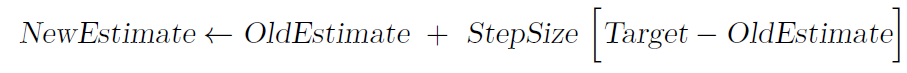

In [48]:
Image('../figs/atualizacao_media.png')

In [64]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        # YOUR CODE HERE
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = [i]
        elif q_values[i] == top_value:
            ties.append(i)
    return np.random.choice(ties)

In [50]:
class GreedyAgent():
    
    def __init__(self, n_actions, **kwargs):
        self.action_space = n_actions
        self.q_values = np.zeros(self.action_space) #armazena a recompensa media
        self.arm_count = np.zeros(self.action_space) #armazena a contagem de vezes que cada alavanca foi acionada
        self.last_action=None
        
        
    def update_q_values(self, reward):
        if not self.last_action:
            return
        qn = self.q_values[self.last_action]
        n = self.arm_count[self.last_action]
        alpha = 1/n
        self.q_values[self.last_action] = qn + alpha*(reward - qn) 
    
    def step(self, reward):
        
        #atualizar a estimativa das recompensas com base na ultima ação
        self.update_q_values(reward)
        self.current_action = argmax(self.q_values)
        self.arm_count[self.current_action]+=1
        self.last_action = self.current_action   
        return self.current_action
    
    def reset(self):
        self.q_values = np.zeros(self.action_space)
        self.arm_count = np.zeros(self.action_space)
        self.last_action=None
        

In [70]:
n_runs = 200
n_steps = 1000
n_alavancas = 10

print(f"Jogando {n_runs} vezes com {n_steps} fichas:")

all_rewards = []
all_max_reward = []

for run in tqdm(range(n_runs)):
    agent = GreedyAgent(n_actions=n_alavancas)
    run_reward = []
    run_best_reward = []
    reward = 0
    for n in range(n_steps):
        
        #aqui entra nosso agente
        action = agent.step(reward)
        state, reward, terminal, info = env.step(action)

        run_reward.append(reward)
        run_best_reward.append(np.max(env.values))
    
    all_rewards.append(run_reward)
    all_max_reward.append(run_best_reward)
    
avg_reward = np.mean(all_rewards, axis=0)
avg_best_reward = np.mean(all_max_reward,axis=0)

res = pd.DataFrame(zip(avg_reward, avg_best_reward), columns=['recompensa_media', 'recompensa_maxima'])
aproveitamento = np.round(100*res['recompensa_media'].sum()/res['recompensa_maxima'].sum(),1)
print(f'Feito! Aproveitamento: {aproveitamento}%')

  2%|█▋                                                                                | 4/200 [00:00<00:13, 14.30it/s]

Jogando 200 vezes com 1000 fichas:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.93it/s]

Feito! Aproveitamento: 64.3%


In [71]:
fig = px.line(res[['recompensa_media', 'recompensa_maxima']])
fig.update_layout({
    'title': '10-Armed Bandits Testbed - Greedy Agent',
    'xaxis_title': 'Ficha',
    'yaxis_title': 'Recompensa média'
})

In [72]:
pd.DataFrame(zip(agent.q_values,env.values), columns = ['recompensa aprendida', 'recompensa real']).round(3)

,recompensa aprendida,recompensa real
0,0.000,1
1,0.000,6
2,0.000,6
3,0.000,5
4,0.000,7
5,6.989,7
6,0.000,2
7,0.000,9
8,0.000,5
9,0.000,7


## Como melhorar?

Nosso agente anterior utilizou a primeira informação de recompensa disponível para todas as jogadas. Era a única recompensa que ele conhecia diferente de zero. <b> Isso quer dizer que as outras alavancas tinham recompensa zero? </b>

Vamos testar um agente que, mesmo conhecendo alavancas diferente de zero, eventualmente explora novas ações, mesmo que a recompensa imediata possa ser pior:

In [54]:
class EpsilonGreedyAgent():
    
    def __init__(self, n_actions, epsilon=0.05):
        self.action_space = n_actions
        self.q_values = np.zeros(self.action_space) #armazena a recompensa media
        self.arm_count = np.zeros(self.action_space) #armazena a contagem de vezes que cada alavanca foi acionada
        self.epsilon = epsilon
        self.last_action = None
        
    def update_q_values(self, reward):
        qn = self.q_values[self.last_action]
        n = self.arm_count[self.last_action]
        alpha = 1/n
        self.q_values[self.last_action] = qn + alpha*(reward - qn) 
    
    def step(self, reward):
        
        #atualizar a estimativa das recompensas com base na ultima ação
        if self.last_action:
            self.update_q_values(reward)
        
        if np.random.random() < self.epsilon:
            self.current_action = np.random.randint(self.action_space)
        else:
            self.current_action = argmax(self.q_values)
            
        self.arm_count[self.current_action]+=1
        self.last_action = self.current_action              
        return self.current_action
    
    def reset(self):
        self.q_values = np.zeros(self.action_space)
        self.arm_count = np.zeros(self.action_space)
        self.last_action=None
        

In [74]:
n_runs = 200
n_steps = 1000
n_alavancas = 10

print(f"Jogando {n_runs} vezes com {n_steps} fichas:")

all_rewards = []
all_max_reward = []

for run in tqdm(range(n_runs)):
    agent = EpsilonGreedyAgent(n_actions=n_alavancas)
    run_reward = []
    run_best_reward = []
    reward = 0
    for n in range(n_steps):
        
        #aqui entra nosso agente
        action = agent.step(reward)
        state, reward, terminal, info = env.step(action)

        run_reward.append(reward)
        run_best_reward.append(np.max(env.values))
    
    all_rewards.append(run_reward)
    all_max_reward.append(run_best_reward)
    
avg_reward = np.mean(all_rewards, axis=0)
avg_best_reward = np.mean(all_max_reward,axis=0)

res = pd.DataFrame(zip(avg_reward, avg_best_reward), columns=['recompensa_media', 'recompensa_maxima'])
aproveitamento = np.round(100*res['recompensa_media'].sum()/res['recompensa_maxima'].sum(),1)
print(f'Feito! Aproveitamento: {aproveitamento}%')

  1%|▊                                                                                 | 2/200 [00:00<00:11, 16.64it/s]

Jogando 200 vezes com 1000 fichas:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.53it/s]

Feito! Aproveitamento: 93.0%


In [75]:
pd.DataFrame(zip(agent.q_values,env.values), columns = ['recompensa aprendida', 'recompensa real']).round(3)

,recompensa aprendida,recompensa real
0,0.000,1
1,6.132,6
2,6.457,6
3,5.060,5
4,7.319,7
5,6.805,7
6,3.660,2
7,8.976,9
8,5.556,5
9,6.543,7


In [76]:
fig = px.line(res[['recompensa_media', 'recompensa_maxima']])
fig.update_layout({
    'title': '10-Armed Bandits Testbed - Epsilon Greedy Agent (0.05)',
    'xaxis_title': 'Ficha',
    'yaxis_title': 'Recompensa média'
})

## Comparando diferentes agentes

Pelo ultimo teste, ficou claro que para esse ambiente é necessário explorar, mas explorar quanto? Para responder essa questão, podemos ampliar nosso experimento considerando diferentes Epsilon-Greedy Agents:
- Aleatorio: nunca aprende com ações passadas;
- Greedy: sempre busca a ação de maior recompensa conhecida no momento;
- E-greedy: busca a ação de maior recompensa com probabilidade de explorar em E% das vezes;

In [77]:
#vamos iniciar implantando um agente aleatorio no mesmo padrão
class RandomAgent():
    def __init__(self, n_actions, **kwargs):
        self.action_space = n_actions
    
    def step(self, reward):
        action = np.random.randint(self.action_space)
        return action
    
    def reset(self):
        pass

In [78]:
n_runs = 200
n_steps = 1000
n_alavancas = 10

agentes = {
    'Aleatorio': RandomAgent(n_actions = n_alavancas),
    'Greedy': GreedyAgent(n_actions = n_alavancas),
    'Epsilon_0.01': EpsilonGreedyAgent(n_actions = n_alavancas, epsilon=0.01),
    'Epsilon_0.05': EpsilonGreedyAgent(n_actions = n_alavancas, epsilon=0.1),
    'Epsilon_0.1': EpsilonGreedyAgent(n_actions = n_alavancas, epsilon=0.1),
    'Epsilon_0.3': EpsilonGreedyAgent(n_actions = n_alavancas, epsilon=0.3),
    'Epsilon_0.5': EpsilonGreedyAgent(n_actions = n_alavancas, epsilon=0.5),
}

all_agents_res = []

for name, agent in agentes.items():
    print(f"Agente: {name} Jogando {n_runs} vezes com {n_steps} fichas:")

    all_rewards = []
    all_max_reward = []

    for run in tqdm(range(n_runs)):
        
        run_reward = []
        run_best_reward = []
        reward = 0
        for n in range(n_steps):

            #aqui entra nosso agente
            action = agent.step(reward)
            state, reward, terminal, info = env.step(action)

            run_reward.append(reward)
            run_best_reward.append(np.max(env.values))

        all_rewards.append(run_reward)
        all_max_reward.append(run_best_reward)
        agent.reset()

    avg_reward = np.mean(all_rewards, axis=0)
    avg_best_reward = np.mean(all_max_reward,axis=0)

    res = pd.DataFrame(zip(avg_reward, avg_best_reward), columns=['recompensa_media', 'recompensa_maxima'])
    aproveitamento = np.round(100*res['recompensa_media'].sum()/res['recompensa_maxima'].sum(),1)
    print(f'Feito! Aproveitamento agente {name}: {aproveitamento}%')
    res['agente'] = name
    
    all_agents_res.append(res)
all_res = pd.concat(all_agents_res)

  2%|█▋                                                                                | 4/200 [00:00<00:06, 31.50it/s]

Agente: Aleatorio Jogando 200 vezes com 1000 fichas:


  2%|█▏                                                                                | 3/200 [00:00<00:09, 21.18it/s]

Feito! Aproveitamento agente Aleatorio: 61.1%
Agente: Greedy Jogando 200 vezes com 1000 fichas:


  2%|█▏                                                                                | 3/200 [00:00<00:08, 22.90it/s]

Feito! Aproveitamento agente Greedy: 66.1%
Agente: Epsilon_0.01 Jogando 200 vezes com 1000 fichas:


  2%|█▏                                                                                | 3/200 [00:00<00:08, 22.39it/s]

Feito! Aproveitamento agente Epsilon_0.01: 84.3%
Agente: Epsilon_0.05 Jogando 200 vezes com 1000 fichas:


  2%|█▋                                                                                | 4/200 [00:00<00:11, 17.15it/s]

Feito! Aproveitamento agente Epsilon_0.05: 94.1%
Agente: Epsilon_0.1 Jogando 200 vezes com 1000 fichas:


  2%|█▏                                                                                | 3/200 [00:00<00:08, 22.32it/s]

Feito! Aproveitamento agente Epsilon_0.1: 94.0%
Agente: Epsilon_0.3 Jogando 200 vezes com 1000 fichas:


  3%|██▍                                                                               | 6/200 [00:00<00:09, 20.18it/s]

Feito! Aproveitamento agente Epsilon_0.3: 87.7%
Agente: Epsilon_0.5 Jogando 200 vezes com 1000 fichas:


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.44it/s]

Feito! Aproveitamento agente Epsilon_0.5: 80.3%


In [79]:
fig = px.line(all_res[['recompensa_media', 'recompensa_maxima']], color=all_res['agente'])
fig.update_layout({
    'title': '10-Armed Bandits Testbed - Comparação entre agentes',
    'xaxis_title': 'Ficha',
    'yaxis_title': 'Recompensa média'
})

Essa comparação nos dá a intuição de um conceito essencial em RL: <b> Exploration vs Exploitation </b>:
- se o agente focar somente na recompensa imediata (utilizando o conhecimento que ele tem até então), ele não descobrirá melhores ações porqueque no instante atual elas parecem ser piores do que ele já conhece;

- se o agente explorar novas ações, estará sacrificando obter uma recompensa imediata conhecida em função de uma melhor recompensa futura;

Nesse ambiente explorado, percebe-se que as ações tomadas não alteram a distribuição de recompensas ou estado do ambiente. <b> Como seria se alterasse? </b>